In [53]:
# lectura de datos 
from ssconnect import connect_singlestore
import pandas as pd
import datetime as dt


engine = connect_singlestore()
sql="SELECT * FROM DWH.VW_VENTA_VS_MANTENIMIENTO WHERE FAMILIA_VH NOT IN ('NO DEFINIDO','YARIS GR')"
df_prep= pd.read_sql(sql, engine)
df_prep = df_prep[df_prep['TIPO_DOCUMENTO'] == 'FACTURA CREDITO']
df_prep = df_prep.sort_values('FECHA', ascending=False)
df_prep = df_prep.drop_duplicates(subset=['CHASIS'], keep='first')
df_prep['FECHA'] = pd.to_datetime(df_prep['FECHA'], format='%Y-%m-%d', errors='coerce')
df_prep = df_prep[df_prep['FECHA'] < dt.datetime(2025, 1, 1)]
df_prep.reset_index(drop=True, inplace=True)

# Convertir las columnas de fecha a tipo datetime
df_prep['FECHA_SALIDA'] = pd.to_datetime(df_prep['FECHA_SALIDA'], format='%Y-%m-%d', errors='coerce')
df_prep['FECHA_MNT_1000'] = pd.to_datetime(df_prep['FECHA_MNT_1000'], format='%Y-%m-%d', errors='coerce')
df_prep['FECHA_MNT_1000_2'] = pd.to_datetime(df_prep['FECHA_MNT_1000'], format='%Y-%m-%d', errors='coerce')
# Si FECHA_MNT_1000 es 1970-01-01 , colocar la fecha de hoy
df_prep['FECHA_MNT_1000_2'] = df_prep['FECHA_MNT_1000_2'].where(df_prep['FECHA_MNT_1000_2'] > dt.datetime(1970, 1, 1), dt.datetime.today())
# Calcular la diferencia en días entre LA FECHA  y el primer mantenimiento
df_prep['TIEMPO_MANT_1000'] = (df_prep['FECHA_MNT_1000_2'] - df_prep['FECHA']).dt.days
# Crear una columna de evento (si hubo mantenimiento o no)
df_prep['EVENTO_MANT_1000'] = df_prep['MANTENIMIENTO_1000'].apply(lambda x: 1 if x > 0 else 0)
# quitar los registos con timepo mant negativos
df_prep = df_prep[df_prep['TIEMPO_MANT_1000'] >= 0]
# los registros que tienen mas de 120 dias hasta el primer mantenimiento se consideran censurados
df_prep['EVENTO_MANT_1000'] = df_prep['EVENTO_MANT_1000'].where(df_prep['TIEMPO_MANT_1000'] <= 120, 0)

#crear la columna de censura, si el tiempo hasta el primer mantenimiento es mayor a 120 dias se considera censurado de igual manera los que tienen fecha de mantenimiento 1970-01-01
df_prep['CENSURA'] = df_prep['TIEMPO_MANT_1000'].apply(lambda x: 1 if x > 120 else 0)
# los registros que tienen fecha de mantenimiento 1970-01-01 se consideran censurados   
df_prep['CENSURA'] = df_prep['CENSURA'].where(df_prep['FECHA_MNT_1000'] > dt.datetime(1970, 1, 1), 1)
# los registros que son iguales o mayores a 120 dias se considera que no tuvieron mantenimiento
df_prep['TIEMPO_MANT_1000'] = df_prep['TIEMPO_MANT_1000'].where(df_prep['TIEMPO_MANT_1000'] <= 120, 120)
# seleccionar las columnas necesarias para el analisis 
df_prep = df_prep[['CHASIS','TIEMPO_MANT_1000', 'EVENTO_MANT_1000','CENSURA', 'AGENCIA', 'LINEA_NEGOCIO', 'FAMILIA_VH']]
df_prep.head()


,CHASIS,TIEMPO_MANT_1000,EVENTO_MANT_1000,CENSURA,AGENCIA,LINEA_NEGOCIO,FAMILIA_VH
0,8AJCB3DD0S3920300,85,1,0,CONDADO,VEH. NUEVOS TOYOTA,HILUX
1,9BRKZAAG8S0701848,101,0,1,GRANADOS,VEH. NUEVOS TOYOTA,COROLLA CROSS
2,JTDKBABB5SA417389,83,1,0,SUR,VEH. NUEVOS TOYOTA,YARIS CROSS
3,MHFBU3FS0S0352770,101,0,1,SANTO DOMINGO,VEH. NUEVOS TOYOTA,FORTUNER
4,8AJCB3DD2S3920542,101,0,1,GRANADOS,VEH. NUEVOS TOYOTA,HILUX


In [65]:
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
from lifelines import  KaplanMeierFitter
import matplotlib.pyplot as plt

# Asegúrate de que 'EVENTO_MANT_1000' es tu indicador de evento (1=evento, 0=censura)
# y 'TIEMPO_MANT_1000' es tu tiempo hasta el evento o censura.
df_prep = df_prep[['TIEMPO_MANT_1000', 'EVENTO_MANT_1000', 'AGENCIA',  'FAMILIA_VH']]

# Codificar variables categóricas como variables dummy
df_prep_encoded = pd.get_dummies(df_prep, columns=['AGENCIA', 'FAMILIA_VH'], drop_first=True)

# Dividir los datos en entrenamiento y prueba
train_df, test_df = train_test_split(df_prep_encoded, test_size=0.2, random_state=42, stratify=df_prep_encoded['EVENTO_MANT_1000'])

# Inicializar el modelo de riesgos proporcionales de Cox
cph = CoxPHFitter()

# Ajustar el modelo con los datos de entrenamiento
cph.fit(train_df, duration_col='TIEMPO_MANT_1000', event_col='EVENTO_MANT_1000')

# Imprimir el resumen del modelo (coeficientes, riesgos relativos, significancia)
print("\nResumen del modelo de Cox:")
cph.print_summary()

# Evaluar el modelo en el conjunto de prueba usando el índice de concordancia (C-index)
c_index = cph.score(test_df)
print(f"\nÍndice de Concordancia (C-index) en el conjunto de prueba: {c_index:.3f}")

# --- Visualizaciones Opcionales ---




Resumen del modelo de Cox:


<lifelines.CoxPHFitter: fitted with 17679 total observations, 5394 right-censored observations>
             duration col = 'TIEMPO_MANT_1000'
                event col = 'EVENTO_MANT_1000'
      baseline estimation = breslow
   number of observations = 17679
number of events observed = 12285
   partial log-likelihood = -114007.50
         time fit was run = 2025-04-11 23:49:23 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                  
AGENCIA_COCA              -1.98      0.14      1.01           -3.95           -0.01                0.02                0.99
AGENCIA_CONDADO           -1.69      0.18      1.00           -3.65            0.27                0.03                1.31
AGENCIA_CUMBAYA           -1.98      0.14      1.00           -3.94           -0.02                0.02                0.98
AGENCIA_GRANADOS          -1.87      0.15      1.00           -3.83            0.09                0.02                1.10
AGENCIA_JARDIN            -1.87      0.15      1.00           -3.83            0.09                0.02                1.09
AGENCIA_LOS CHILLOS       -1.39      0.25      1.00           -3.35            0.57                0.04                1.77
AGENCIA_MATRIZ            -1.93      0.14      1.00           -3.90            0.03                0.02                1.03
AGENCIA_SANTO DOMINGO     -1.63      0.20      1.00           -3.59            0.33                0.03                1.40
AGENCIA_SUR               -1.79      0.17      1.00           -3.75            0.17                0.02                1.18
FAMILIA_VH_CHR             0.14      1.15      0.12           -0.09            0.37                0.92                1.45
FAMILIA_VH_COROLLA         0.08      1.09      0.10           -0.11            0.28                0.89                1.32
FAMILIA_VH_COROLLA CROSS   0.25      1.29      0.08            0.10            0.40                1.11                1.49
FAMILIA_VH_FORTUNER        0.10      1.10      0.08           -0.05            0.24                0.95                1.27
FAMILIA_VH_HILUX          -0.01      0.99      0.07           -0.15            0.14                0.86                1.15
FAMILIA_VH_INNOVA          0.45      1.57      0.21            0.04            0.86                1.04                2.36
FAMILIA_VH_LAND CRUISER   -0.23      0.79      0.10           -0.43           -0.03                0.65                0.97
FAMILIA_VH_PRIUS           0.22      1.25      0.09            0.04            0.40                1.04                1.50
FAMILIA_VH_RAIZE           0.16      1.17      0.08            0.00            0.32                1.00                1.37
FAMILIA_VH_RAV4            0.19      1.21      0.08            0.04            0.34                1.04                1.41
FAMILIA_VH_RUSH            0.10      1.11      0.08           -0.05            0.25                0.95                1.29
FAMILIA_VH_YARIS           0.24      1.27      0.08            0.09            0.39                1.10                1.47
FAMILIA_VH_YARIS CROSS     0.20      1.22      0.10           -0.00            0.40                1.00                1.49

                           cmp to     z      p  -log2(p)
covariate                                               
AGENCIA_COCA                 0.00 -1.97   0.05      4.36
AGENCIA_CONDADO              0.00 -1.69   0.09      3.46
AGENCIA_CUMBAYA              0.00 -1.98   0.05      4.39
AGENCIA_GRANADOS             0.00 -1.87   0.06      4.01
AGENCIA_JARDIN               0.00 -1.87   0.06      4.03
AGENCIA_LOS CHILLOS          0.00 -1.39   0.16      2.60
AGENCIA_MATRIZ               0.00 -1.93   0.05      4.23
AGENCIA_SANTO DOMINGO        0.00 -1.63   0.10      3.27
AGENCIA_SUR                  0.00 -1.79   0.07      3.77
FAMILI


Índice de Concordancia (C-index) en el conjunto de prueba: -5.490


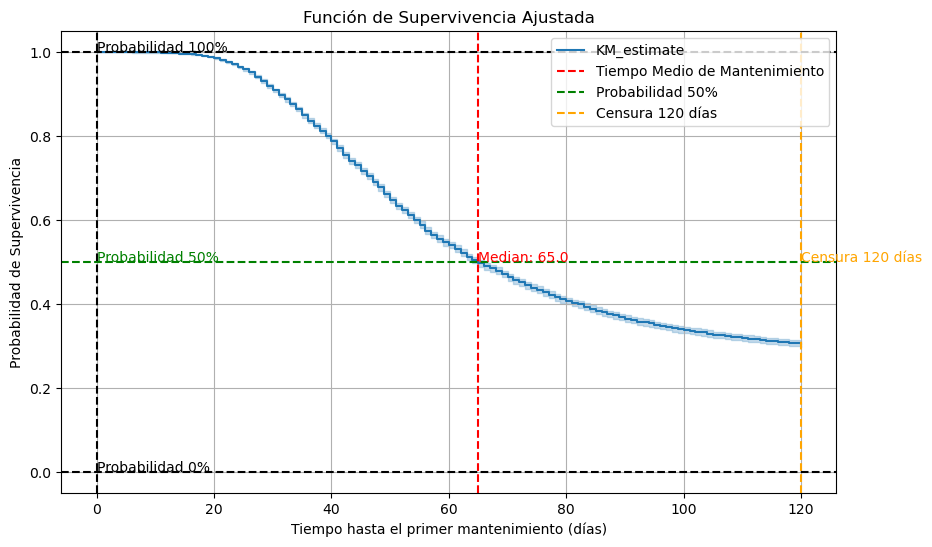

In [60]:
# Visualizar la función de supervivencia ajustada, marcar el tiempo medio de mantenimiento , colocar etiqueta de valor
plt.figure(figsize=(10, 6))
kmf = KaplanMeierFitter()
kmf.fit(durations=train_df['TIEMPO_MANT_1000'], event_observed=train_df['EVENTO_MANT_1000'])
kmf.plot_survival_function()
plt.title('Función de Supervivencia Ajustada')
plt.xlabel('Tiempo hasta el primer mantenimiento (días)')
plt.ylabel('Probabilidad de Supervivencia')
plt.axvline(x=kmf.median_survival_time_, color='r', linestyle='--', label='Tiempo Medio de Mantenimiento')
plt.text(kmf.median_survival_time_, 0.5, f'Median: {kmf.median_survival_time_:.1f}', color='r')
plt.axhline(y=0.5, color='g', linestyle='--', label='Probabilidad 50%')
plt.text(0, 0.5, 'Probabilidad 50%', color='g')
plt.axvline(x=120, color='orange', linestyle='--', label='Censura 120 días')
plt.text(120, 0.5, 'Censura 120 días', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.text(0, 0, 'Probabilidad 0%', color='black')
plt.axhline(y=1, color='black', linestyle='--')
plt.text(0, 1, 'Probabilidad 100%', color='black')
plt.axvline(x=0, color='black', linestyle='--')
plt.legend()
plt.grid()





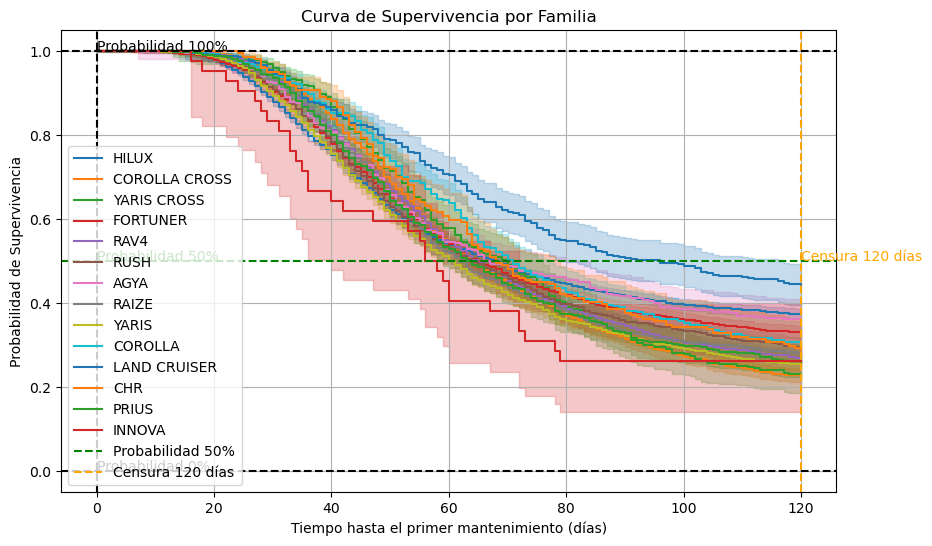

In [62]:
# curva de supervivencia por familia
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for family in df_prep['FAMILIA_VH'].unique():
    mask = df_prep['FAMILIA_VH'] == family
    kmf.fit(durations=df_prep.loc[mask, 'TIEMPO_MANT_1000'], event_observed=df_prep.loc[mask, 'EVENTO_MANT_1000'], label=family)
    kmf.plot_survival_function()
plt.title('Curva de Supervivencia por Familia')
plt.xlabel('Tiempo hasta el primer mantenimiento (días)')
plt.ylabel('Probabilidad de Supervivencia')
plt.axhline(y=0.5, color='g', linestyle='--', label='Probabilidad 50%')
plt.text(0, 0.5, 'Probabilidad 50%', color='g')
plt.axvline(x=120, color='orange', linestyle='--', label='Censura 120 días')
plt.text(120, 0.5, 'Censura 120 días', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.text(0, 0, 'Probabilidad 0%', color='black')
plt.axhline(y=1, color='black', linestyle='--')
plt.text(0, 1, 'Probabilidad 100%', color='black')
plt.axvline(x=0, color='black', linestyle='--')
plt.legend()
plt.grid()


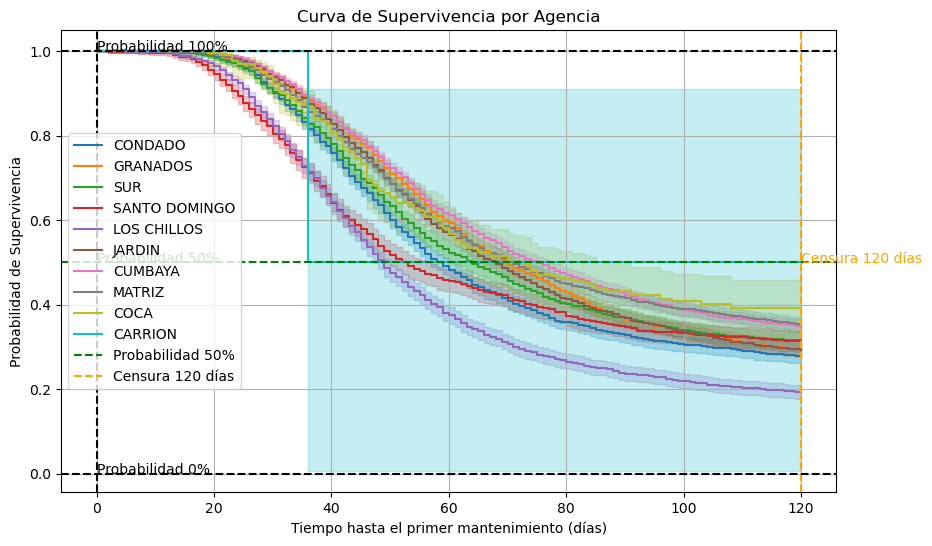

In [77]:
# curvas de supervivencia por agencia
kmf = KaplanMeierFitter()
plt.figure(figsize=(10, 6))
for agency in df_prep['AGENCIA'].unique():
    mask = df_prep['AGENCIA'] == agency
    kmf.fit(durations=df_prep.loc[mask, 'TIEMPO_MANT_1000'], event_observed=df_prep.loc[mask, 'EVENTO_MANT_1000'], label=agency)
    kmf.plot_survival_function()
plt.title('Curva de Supervivencia por Agencia')
plt.xlabel('Tiempo hasta el primer mantenimiento (días)')
plt.ylabel('Probabilidad de Supervivencia')
plt.axhline(y=0.5, color='g', linestyle='--', label='Probabilidad 50%')
plt.text(0, 0.5, 'Probabilidad 50%', color='g')
plt.axvline(x=120, color='orange', linestyle='--', label='Censura 120 días')
plt.text(120, 0.5, 'Censura 120 días', color='orange')
plt.axhline(y=0, color='black', linestyle='--')
plt.text(0, 0, 'Probabilidad 0%', color='black')
plt.axhline(y=1, color='black', linestyle='--')
plt.text(0, 1, 'Probabilidad 100%', color='black')
plt.axvline(x=0, color='black', linestyle='--')
plt.legend()
plt.grid()


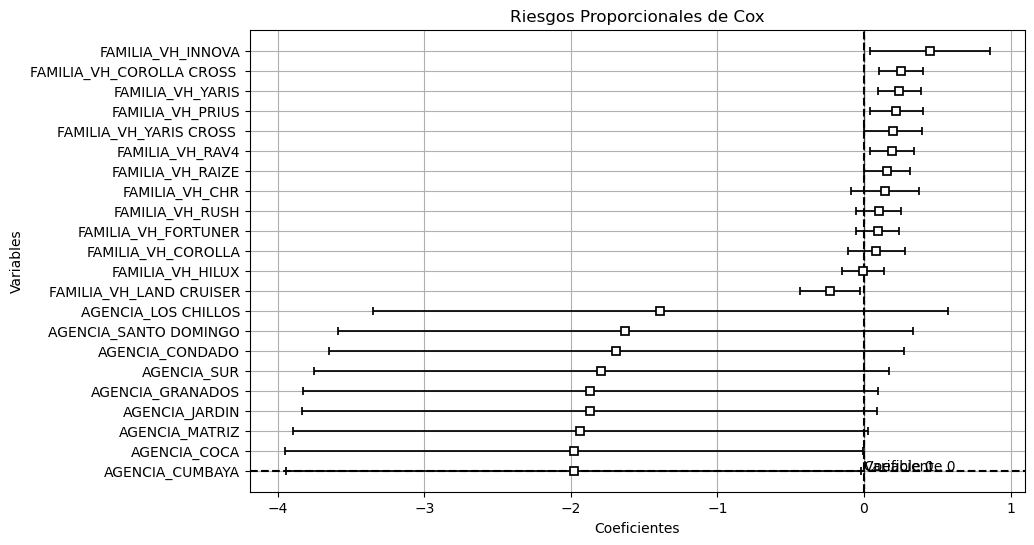

In [76]:
# grafico de riesgos proporcionales de Cox
plt.figure(figsize=(10, 6))
cph.plot()
plt.title('Riesgos Proporcionales de Cox')
plt.xlabel('Coeficientes')
plt.ylabel('Variables')
plt.axvline(x=0, color='black', linestyle='--')
plt.text(0, 0, 'Coeficiente 0', color='black')  
plt.axhline(y=0, color='black', linestyle='--')
plt.text(0, 0, 'Variable 0', color='black')
plt.grid()